# Wine

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/ml/blob/main/notebooks/wine.ipynb)
[![Render nbviewer](https://img.shields.io/badge/render-nbviewer-f37726)](https://nbviewer.org/github/adamelliotfields/ml/blob/main/notebooks/wine.ipynb)

EDA on the [Wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) dataset.

**Contents**
* [Summary](#summary): DataFrame information and summary statistics.
* [Distribution](#distribution): Combining different plots to visualize the distribution of features.
* [Missing Values](#missing-values): Visualize and handle missing data.
* [Correlation](#correlation): Different ways to visualize correlation.
* [Feature Engineering](#feature-engineering): Creating new predictive features from existing data.
* [Feature Selection](#feature-selection): Use decision trees to determine the most important features.
* [Dimensionality Reduction](#dimensionality-reduction): 2D and 3D projections of the dataset using t-SNE and UMAP.

In [2]:
import subprocess
import sys

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from importlib.util import find_spec
from scipy.stats import kurtosis, median_abs_deviation, mode, norm, skew
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import FeatureImportances

if not find_spec("umap"):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn[plot]"])

from umap import UMAP

In [3]:
wine = load_wine()
wine_X, wine_y, wine_feature_names = wine.data, wine.target, wine.feature_names

wine_df = pd.DataFrame(
    np.c_[wine.data, wine.target],
    columns=np.append(wine_feature_names, ["target"]),
).astype({"target": int})

wine_df.sample(5, random_state=42)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
19,13.64,3.10,2.56,15.2,116.0,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845.0,0
45,14.21,4.04,2.44,18.9,111.0,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080.0,0
140,12.93,2.81,2.70,21.0,96.0,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600.0,2
30,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
67,12.37,1.17,1.92,19.6,78.0,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510.0,1


## Summary

Typically you start with `df.info` and `df.describe()` to get an overview of the data. You can combine with additional stats:
* `mode`: most frequent value
* `range`: quick snapshot of the data's spread
* `IQR`: interquartile range is the difference between the 75th and 25th percentiles; more robust to outliers than range
* `MAD`: the median of the absolute deviations (residuals) from the data's median; more robust to outliers than mean-based measurements
* `CV`: coefficient of variation compares the standard deviation to the mean; a measure of relative variability unaffected by scale
* `skewness`: a positive number indicates right skew, a negative number indicates left skew
* `kurtosis`: measure of the "tailedness" of the distribution
* `unique`: number of unique values; measure of cardinality
* `missing`: number of missing values

If zeros are to be treated the same as missing, convert to `pd.NA` first.

In [4]:
def describe_df(df: pd.DataFrame):
    total = df.shape[0]  # len(df)

    additional_stats = pd.DataFrame(
        {
            "mode": df.apply(lambda x: x.mode()[0], axis=0),
            "range": df.apply(lambda x: x.max() - x.min(), axis=0),
            "IQR": df.apply(lambda x: x.quantile(0.75) - x.quantile(0.25), axis=0),
            "MAD": df.apply(lambda x: median_abs_deviation(x.dropna()), axis=0),
            "CV": df.apply(lambda x: x.std() / x.mean(), axis=0),
            "skewness": df.apply(lambda x: skew(x.dropna()), axis=0),
            "kurtosis": df.apply(lambda x: kurtosis(x.dropna(), fisher=True), axis=0),
            "unique": df.nunique(),
            "missing": df.isnull().sum(),
        }
    )

    # need to transpose (`T`)
    describe = df.describe(percentiles=[]).T.astype({"count": int})

    # rename
    describe.rename(columns={"count": f"count ({total})", "50%": "median"}, inplace=True)

    # merge
    describe = describe.join(additional_stats)

    # add dtypes after merging
    describe["dtype"] = df.dtypes

    return describe

In [5]:
describe_df(wine_df)

,count (178),mean,std,min,median,max,mode,range,IQR,MAD,CV,skewness,kurtosis,unique,missing,dtype
alcohol,178,13.000618,0.811827,11.03,13.050,14.83,12.37,3.80,1.3150,0.680,0.062445,-0.051047,-0.862260,126,0,float64
malic_acid,178,2.336348,1.117146,0.74,1.865,5.80,1.73,5.06,1.4800,0.520,0.478159,1.030869,0.257348,133,0,float64
ash,178,2.366517,0.274344,1.36,2.360,3.23,2.28,1.87,0.3475,0.160,0.115927,-0.175207,1.078576,79,0,float64
alcalinity_of_ash,178,19.494944,3.339564,10.60,19.500,30.00,20.00,19.40,4.3000,2.050,0.171304,0.211247,0.440823,63,0,float64
magnesium,178,99.741573,14.282484,70.00,98.000,162.00,88.00,92.00,19.0000,10.000,0.143195,1.088915,2.012806,53,0,float64
total_phenols,178,2.295112,0.625851,0.98,2.355,3.88,2.20,2.90,1.0575,0.505,0.272689,0.085907,-0.845857,97,0,float64
flavanoids,178,2.029270,0.998859,0.34,2.135,5.08,2.65,4.74,1.6700,0.835,0.492226,0.025129,-0.889365,132,0,float64
nonflavanoid_phenols,178,0.361854,0.124453,0.13,0.340,0.66,0.26,0.53,0.1675,0.085,0.343933,0.446349,-0.652952,39,0,float64
proanthocyanins,178,1.590899,0.572359,0.41,1.555,3.58,1.35,3.17,0.7000,0.380,0.359771,0.512769,0.505671,101,0,float64
color_intensity,178,5.058090,2.318286,1.28,4.690,13.00,2.60,11.72,2.9800,1.510,0.458332,0.861248,0.337370,132,0,float64


## Distribution

Since we have a reasonable amount of features (13), we can visualize all of their distributions at once.

### Histogram

The first figure is a grid of _histograms_. These divide the data into bins and show the frequency of data points within each bin.

The dashed line around the histogram bars is the [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE). It is a smoothed (kernel) version of the histogram. The smoothing makes it easier to identify patterns.

The lighter colored line is the [Probability Density Function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF). It shows what the data would look like if it were a normal distribution. Use it to visualize how the data deviates from normality.

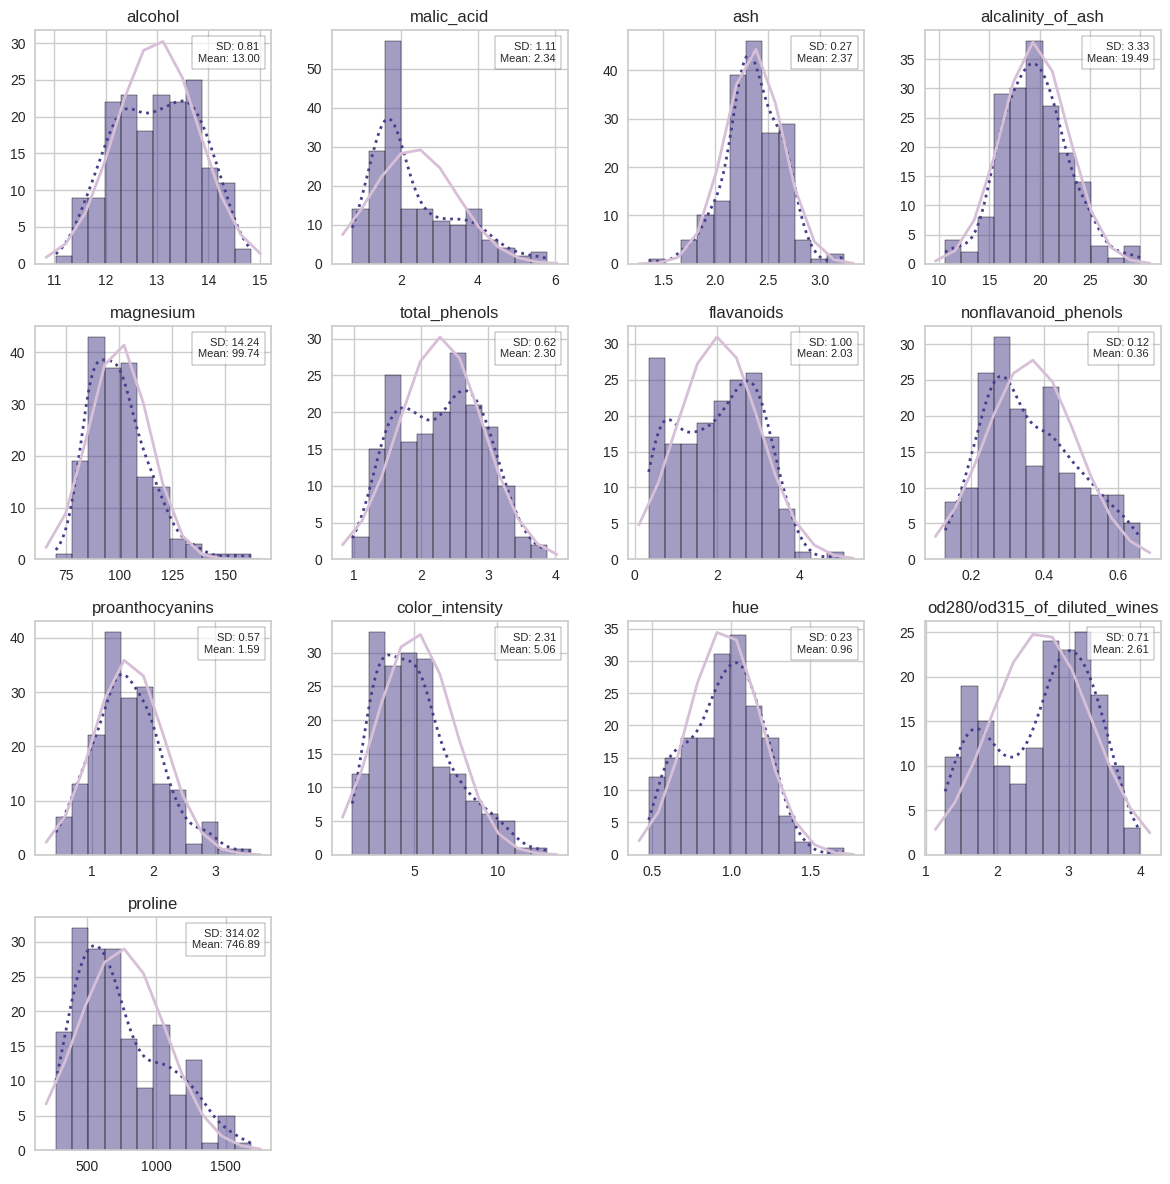

In [6]:
num_features = len(wine_feature_names)
num_cols = min(num_features, 4)
num_rows = (num_features + num_cols - 1) // num_cols
num_bins = 12

# grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()

for i, col in enumerate(wine_feature_names):
    ax = axes[i]
    sns.histplot(
        wine_df[col],
        ax=ax,
        bins=num_bins,
        kde=True,
        color="darkslateblue",
        line_kws={"lw": 2, "ls": ":"},
    )

    # normal distribution fit line
    mu, std = norm.fit(wine_df[col])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, num_bins)
    p = norm.pdf(x, mu, std)
    y = p * wine_df.shape[0] * (xmax - xmin) / num_bins  # scale to match the histogram

    ax.plot(
        x,
        y,
        linewidth=2,
        color="thistle",
    )

    # descriptive stats
    desc_stats = f"SD: {std:.2f}\nMean: {mu:.2f}"
    ax.text(
        0.95,
        0.95,
        desc_stats,
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.7),
    )

    # title and labels
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()

# clean up
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

### Violin

The second figure is a grid of _violin plots_. These are made by mirroring a KDE plot so it looks like a violin.

Inside the violin is a _box plot_. This is a concise summary of the data's distribution. The box itself represents the interquartile range (IQR) (range between 25th and 75th percentiles), which represents the middle 50% of the data. The median is drawn as a vertical line in the box. Extending past the box are _whiskers_. The length of the whiskers is 1.5 times the IQR. Data points beyond the whiskers are considered outliers and marked with circles.

The median line gives us a quick glimpse at the central value of the data while the IQR shows us how concentrated the data is around the median. If the median is not centered in the box or the whiskers are not of equal length, then the data is likely skewed. The length of the whiskers also tells us how much variability there is in the data.

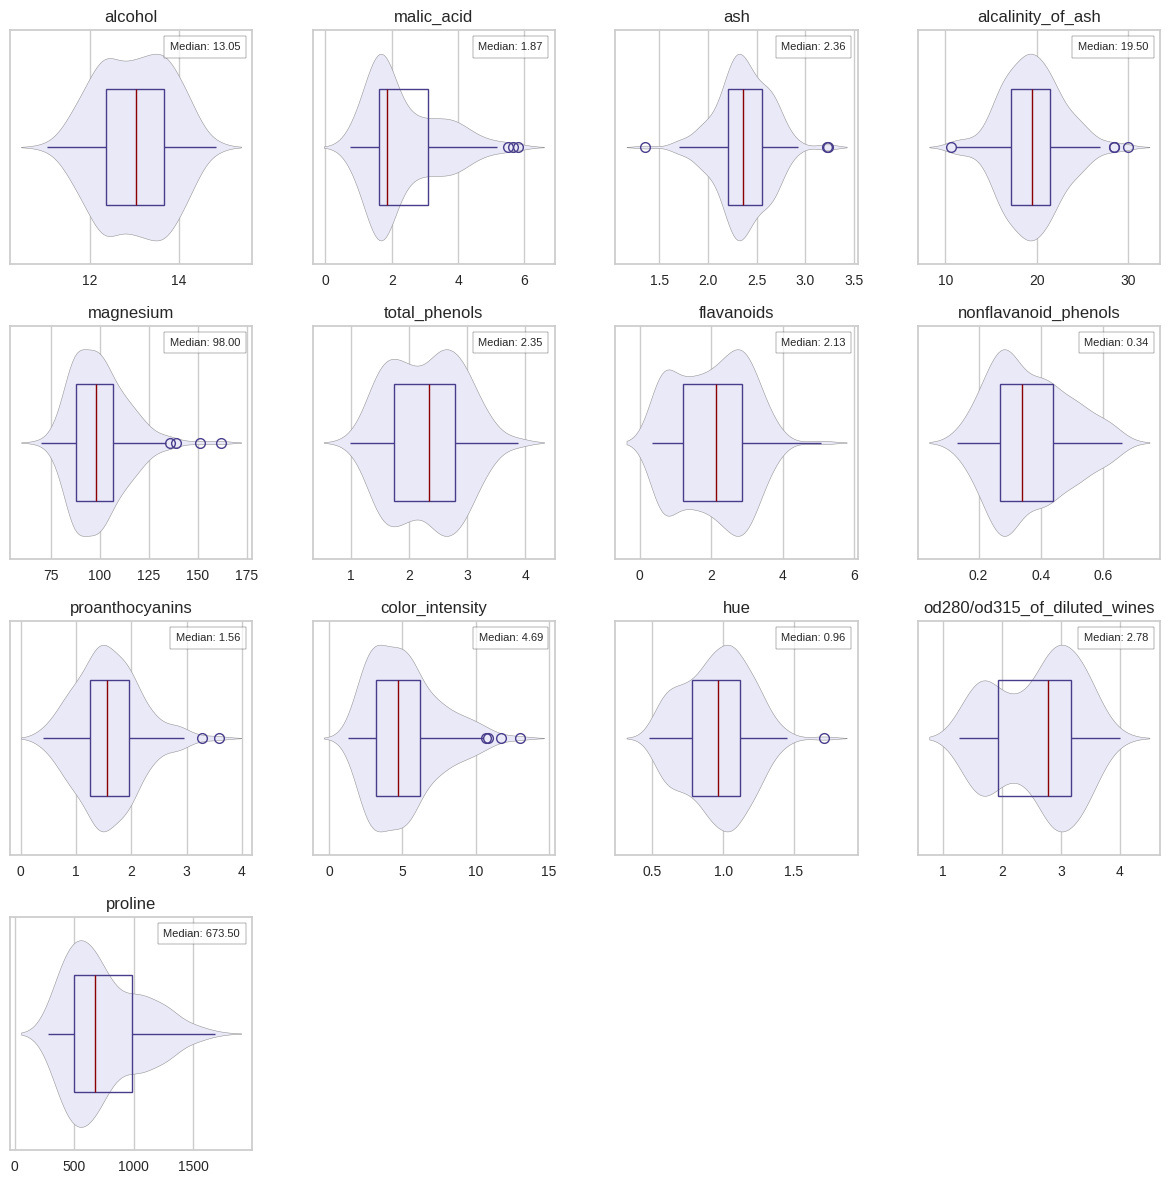

In [7]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()

for i, col in enumerate(wine_feature_names):
    ax = axes[i]

    sns.violinplot(
        x=wine_df[col],
        ax=ax,
        color="lavender",
        inner=None,
    )
    sns.boxplot(
        x=wine_df[col],
        ax=ax,
        width=0.5,
        boxprops={"facecolor": "None", "edgecolor": "darkslateblue"},
        medianprops={"color": "darkred"},
        flierprops={"markeredgecolor": "darkslateblue"},
        whiskerprops={"color": "darkslateblue"},
        showcaps=False,
    )

    median = wine_df[col].median()
    ax.text(
        0.95,
        0.95,
        f"Median: {median:.2f}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.7),
    )

    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()

if num_features < num_rows * num_cols:
    for j in range(num_features, num_rows * num_cols):
        fig.delaxes(axes[j])

## Missing Values

Many of the famous datasets are already clean, so this function adds missing values. Integer types are preserved using Pandas' [nullable integers](https://pandas.pydata.org/docs/user_guide/integer_na.html). You can paste it into another notebook, just make sure Pandas (`pd`) and Numpy (`np`) are imported first.

After applying the function to the dataset, we can inspect it with [missingno](https://github.com/ResidentMario/missingno) library and review techniques for filling the missing data.

In [8]:
def make_no(df: pd.DataFrame, missing_pct=5, ignore=[]) -> pd.DataFrame:
    # clone dataframe
    df = df.copy()

    # determine maskable columns (not ignored)
    maskable_columns = df.columns.difference(ignore)

    # convert integer columns to Pandas nullable integers if not ignored
    int_columns = df[maskable_columns].select_dtypes(include=["int"]).columns
    df[int_columns] = df[int_columns].astype("Int64")

    # calculate how many missing
    df_maskable = df[maskable_columns]
    total_values = df_maskable.size
    total_missing = int(total_values * (missing_pct / 100))

    # create mask
    nan_mask = np.zeros(total_values, dtype=bool)
    nan_indices = np.random.choice(total_values, total_missing, replace=False)
    nan_mask[nan_indices] = True

    # reshape and apply the mask
    nan_mask = nan_mask.reshape(df_maskable.shape)
    df.loc[:, maskable_columns] = df_maskable.mask(nan_mask)

    return df

In [9]:
wine_df_missing = make_no(wine_df, missing_pct=10, ignore=["target"])
describe_df(wine_df_missing)[["missing"]]

,missing
alcohol,22
malic_acid,21
ash,20
alcalinity_of_ash,16
magnesium,10
total_phenols,19
flavanoids,21
nonflavanoid_phenols,16
proanthocyanins,13
color_intensity,18


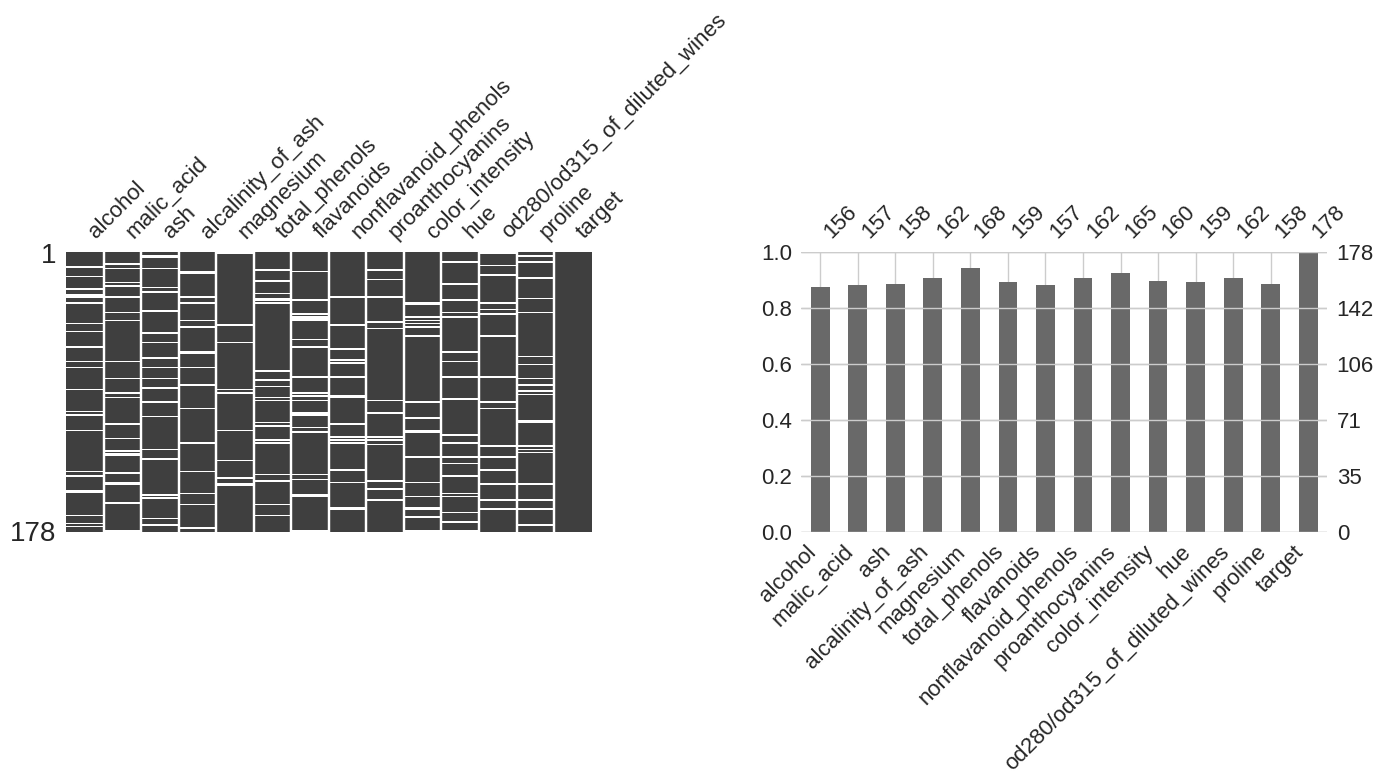

In [10]:
_, axes = plt.subplots(1, 2, figsize=(14, 8))
msno.matrix(wine_df_missing, ax=axes[0], sparkline=False)
msno.bar(wine_df_missing, ax=axes[1])
plt.tight_layout();

### Imputation

There are various ways of handling missing data. If your dataset is big enough you could simply drop the rows or columns that have missing data:
  * rows: `df.dropna()`
  * columns: `df.dropna(axis=1)`

However, in doing so you could be throwing away good data. _Imputation_ is the process of replacing missing data with inferred values. Some common strategies include:
  * mean: `df.fillna(df.mean())`
  * median: `df.fillna(df.median())`
  * mode: `df.fillna(df.mode().iloc[0])`
  * constant: `df.fillna(0)`

In Scikit-learn, you can use `SimpleImputer` or `IterativeImputer` in a pipeline to give your model the ability to handle missing data. Also check out [MICE](https://www.statsmodels.org/stable/generated/statsmodels.imputation.mice.MICE.html).

## Correlation

If your data is normally distributed and you expect linear relationships between features, then use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Note that it is sensitive to outliers.

Otherwise, use [Spearman's $\rho$](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). It is _non-parametric_, which means it does not rely on the data belonging to any particular _parametric_ family of probability distributions. It's also less sensitive to outliers.

Spearman's correlation measures the _monotonic_ relationship between two features, rather than linear. This means that the variables move in the same direction together, but not necessarily at the same rate. In other words, if one variable increases, the other variable always increases. Whereas a linear relationship implies that the variables move in the same direction _and_ at the same rate.

Note that the color palette you choose makes a massive difference in the readability of the heatmap.

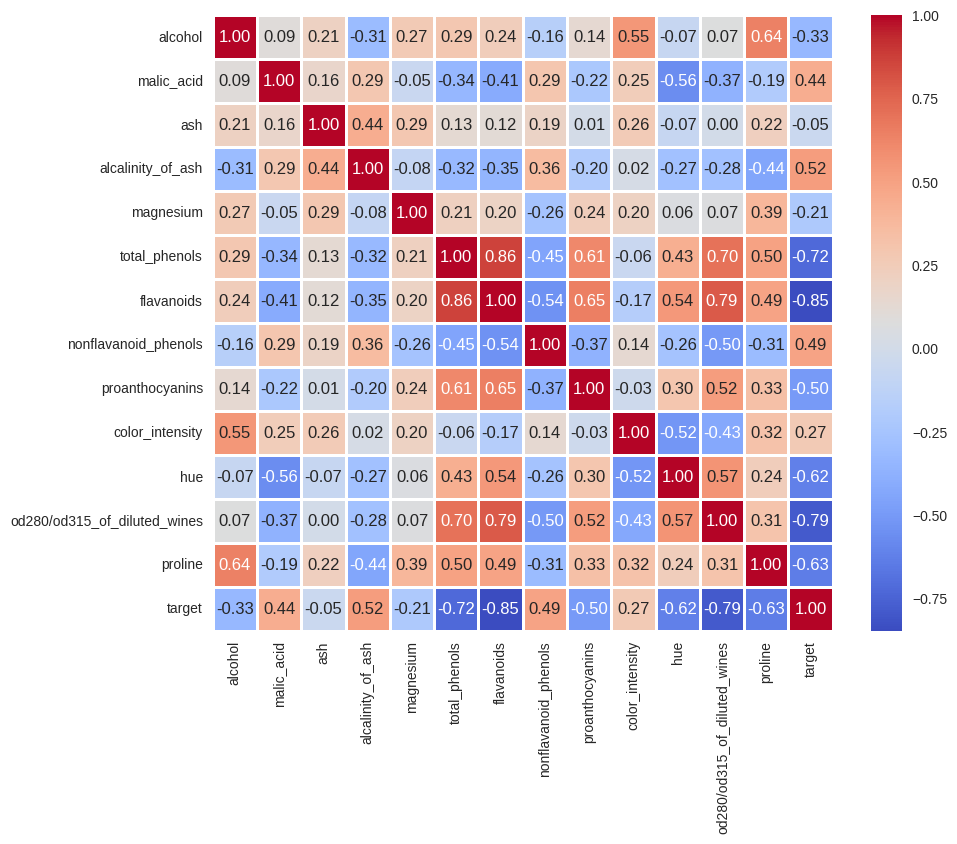

In [11]:
pearson = wine_df.corr()
# spearman = wine_df.corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=2,
);

## Feature Engineering

_Feature engineering_ is the process of transforming raw features into new features that help models make better predictions. This can involve combining or transforming features. For example, multiplying features together or raising a feature to a power allows for non-linear relationships to be captured.

In the wine dataset, new features could be the ratio of nonflavinoid phenols to total phenols or the product of ash and alcalinity of ash.

Domain expertise certainly helps, as I have no idea what _proanthocyanins_ are or how I could use them to categorize wine varietals.

```py
df["phenol_ratio"] = df["nonflavanoid_phenols"] / df["total_phenols"]
df["ash_product"] = df["ash"] * df["alcalinity_of_ash"]
```

## Feature Selection

_Feature selection_ is when you actually pick which features will be used in the model. A popular technique is to use decision trees to determine the most important features.

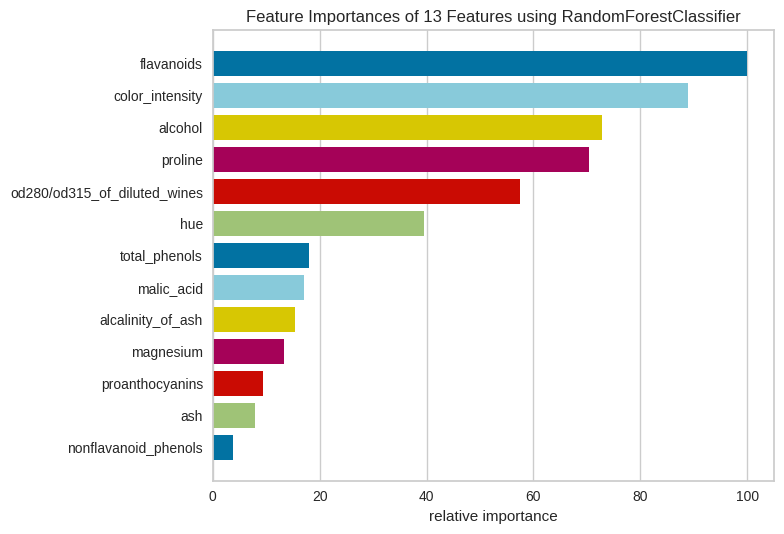

In [12]:
scaler = StandardScaler()
rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42,
)

pipeline = make_pipeline(scaler, rf)
pipeline.fit(wine_X, wine_y)

viz = FeatureImportances(pipeline.named_steps["randomforestclassifier"], labels=wine_feature_names)
viz.fit(wine_X, wine_y)
viz.show();

### Pairwise Relationships

The top features from the random forest classifier are:
  * `flavinoids`
  * `color_intensity`
  * `alcohol`
  * `proline`
  * `od280/od315`

A _pair plot_ plots a matrix of scatter plots with histograms or KDE plots on the diagonal. Look for combinations of features that form defined clusters or trends.

For datasets with more than 5 features you'll want to select some first as the number of relationships to compute grows quadratically. Otherwise, you should use this early in your analysis because it gives a great overview of the data.

To draw regression fit lines in the clusters, use `kind="reg"`.

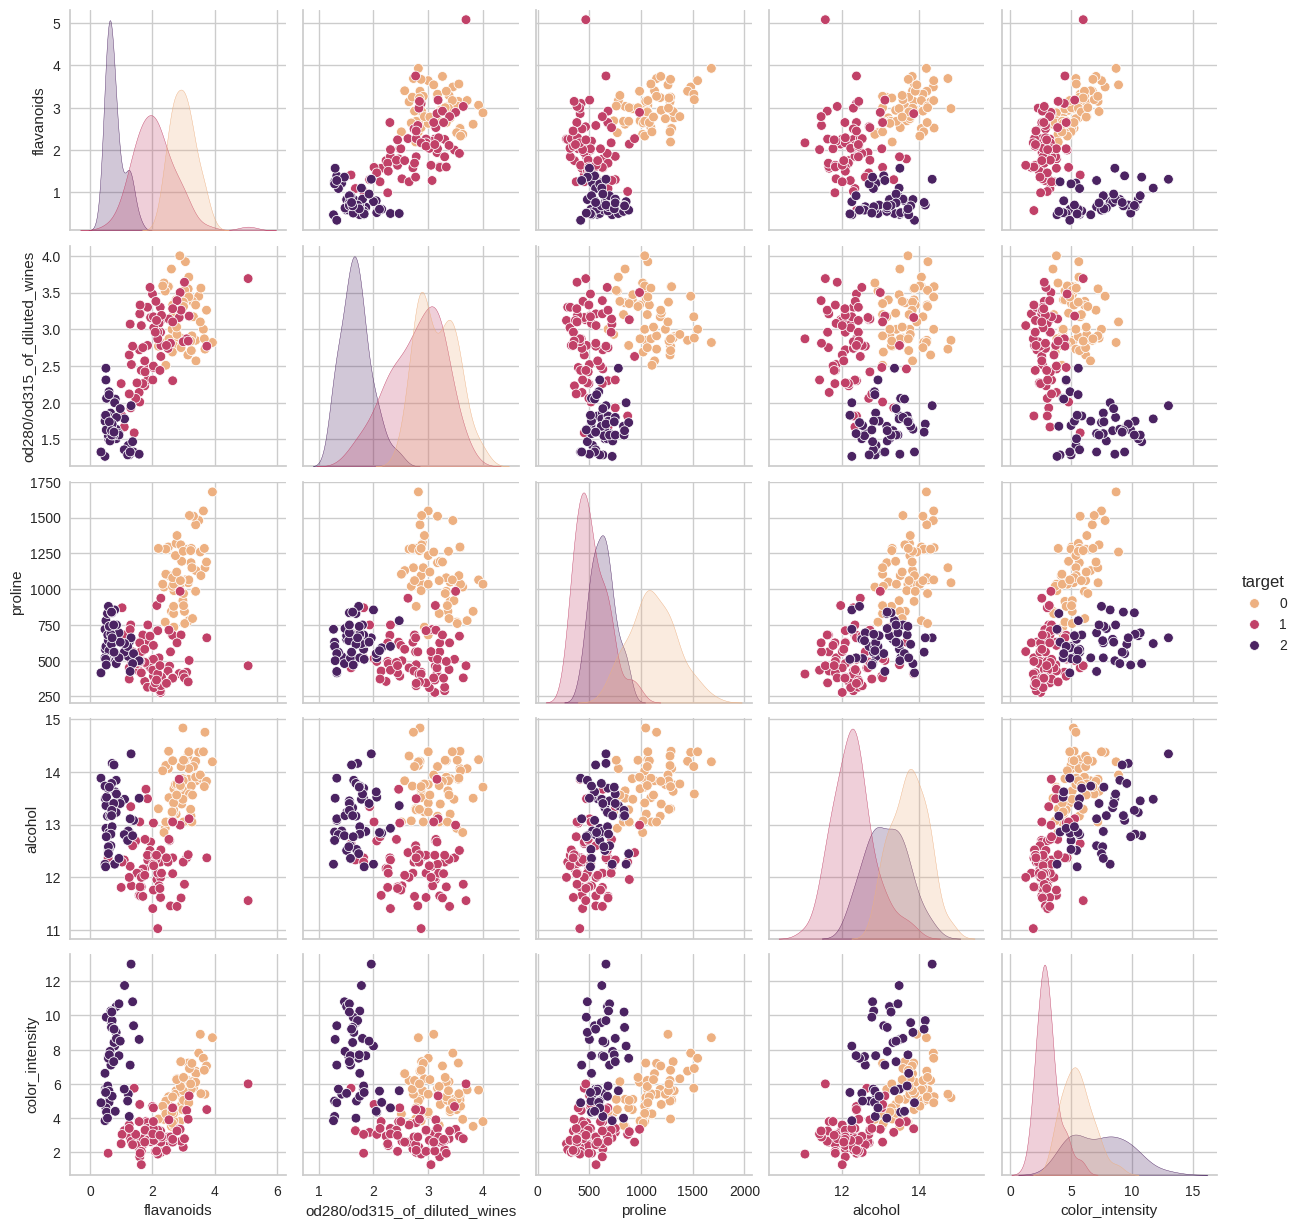

In [13]:
sns.pairplot(
    # pass a subset of columns
    wine_df[
        [
            "flavanoids",
            "od280/od315_of_diluted_wines",
            "proline",
            "alcohol",
            "color_intensity",
            "target",
        ]
    ],
    hue="target",
    diag_kind="kde",
    palette="flare",
);

## Dimensionality Reduction

_Dimensionality reduction_ is a type of unsupervised machine learning that reduces the number of features in a dataset.

For regression problems, you'd use dimensionality reduction to reduce the number of features used when fitting/training a model. When used in feature engineering like this, you need a model that preserves distances (global structure) like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).

For classification problems, you can use dimensionality reduction to visualize the data in 2D or 3D. You'll want to use models that form clusters (local structure) like [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) or [UMAP](https://arxiv.org/abs/1802.03426). For datasets with more than 50 features, it is recommended to use PCA to reduce the dimensionality first before visualizing with t-SNE.

Using t-SNE on the Wine dataset, you'll see that in both 2D and 3D the data points form 3 clusters which correspond to the 3 classes of wine.

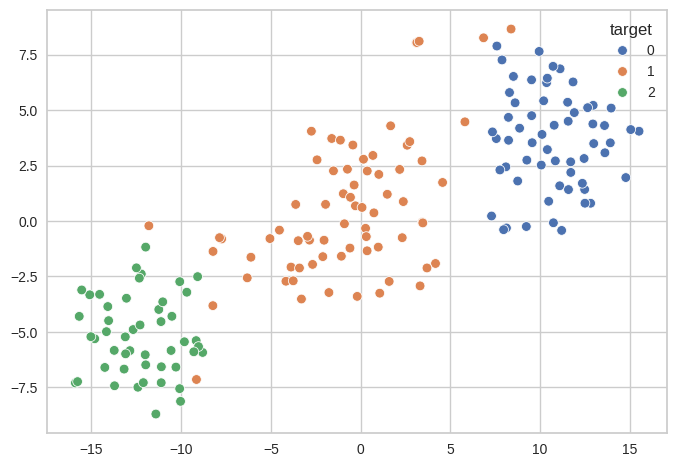

In [14]:
# tsne 2d projection of wine dataset
scaler_tsne = StandardScaler()
tsne = TSNE(n_components=2, n_iter=500, random_state=42)
pipeline = make_pipeline(scaler_tsne, tsne)

wine_tsne = pipeline.fit_transform(wine_df.drop(columns=["target"]))
wine_tsne_x = wine_tsne[:, 0]
wine_tsne_y = wine_tsne[:, 1]

sns.scatterplot(
    x=wine_tsne_x,
    y=wine_tsne_y,
    hue=wine_df.target,
    palette="deep",
);

In [ ]:
# 3D projection using Plotly
scaler_3d = StandardScaler()
tsne_3d = TSNE(n_components=3, n_iter=500, random_state=42)
pipeline_3d = make_pipeline(scaler_3d, tsne_3d)

wine_tsne_3d = pipeline_3d.fit_transform(wine_df.drop(columns=["target"]))
wine_tsne_3d_x = wine_tsne_3d[:, 0]
wine_tsne_3d_y = wine_tsne_3d[:, 1]
wine_tsne_3d_z = wine_tsne_3d[:, 2]

wine_df_plot = pd.DataFrame(
    {
        "x": wine_tsne_3d_x,
        "y": wine_tsne_3d_y,
        "z": wine_tsne_3d_z,
        "class": wine_df["target"],
    }
)

fig = px.scatter_3d(
    wine_df_plot,
    x="x",
    y="y",
    z="z",
    color="class",
    color_continuous_scale="deep",
)
fig.show()

### UMAP

[_Uniform Manifold Approximation and Projection_](https://github.com/lmcinnes/umap) (UMAP) is another dimensionality reduction technique that can be used for visualization. It constructs a high-dimensional graph representation of the data that captures both local neighborhood relationships and global distances. This graph is then optimized to find a low-dimensional representation of the data that preserves these relationships.

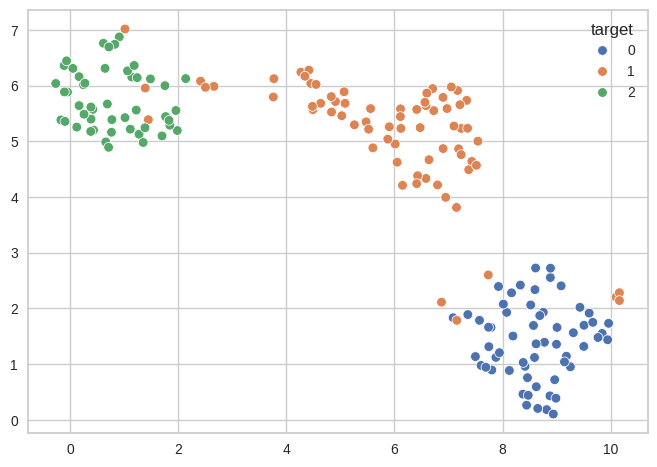

In [16]:
# umap 2d projection of wine dataset
scaler_umap = StandardScaler()
umap = UMAP(n_components=2)
pipeline = make_pipeline(scaler_umap, umap)

wine_umap = pipeline.fit_transform(wine_df.drop(columns=["target"]))
wine_umap_x = wine_umap[:, 0]
wine_umap_y = wine_umap[:, 1]

sns.scatterplot(
    x=wine_umap_x,
    y=wine_umap_y,
    hue=wine_df.target,
    palette="deep",
);

## Notes

### Visualizing skew and kurtosis

_Skewness_ is the measure of the asymmetry of a data distribution.

Both normal and uniform distributions have a skewness of `0`, as they are both symmetric. In a normal (Gaussian) distribution, data points near the mean are more likely to occur than those further away, while in a uniform distribution, all values are equally likely.

A positive skewness indicates a right-skewed distribution, while a negative skewness indicates a left-skewed distribution.

_Kurtosis_ is the measure of the "tailedness" of a data distribution.

Our normal distribution is _mesokurtic_ because its kurtosis is around 3. The skewed distributions are _leptokurtic_ because the kurtosis is greater than 3. A uniform distribution would be _platykurtic_ (less than 3). A higher kurtosis suggests a higher probability of extreme values.

Passing `fisher=True` when calculating kurtosis will use Fisher's definition, which subtracts 3 (i.e., mesokurtic is now 0). This is also known as _excess kurtosis_.

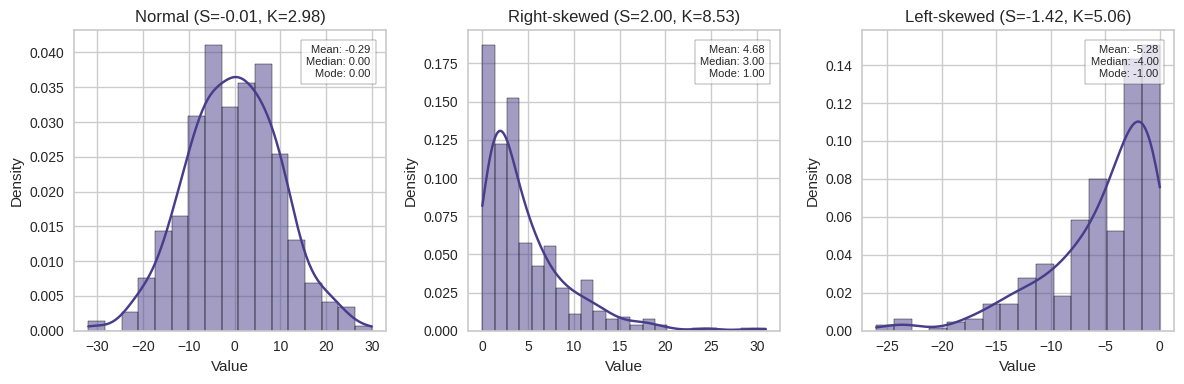

In [17]:
data_normal = np.random.normal(loc=0, scale=1, size=400)  # mean=0, std=1
data_right_skewed = np.random.exponential(scale=1, size=400)  # exponential distribution
data_left_skewed = -np.random.exponential(scale=1, size=400)  # negative exponential distribution

# increase scale and round to ints
data_normal = (data_normal * 10).round().astype(int)
data_right_skewed = (data_right_skewed * 5).round().astype(int)
data_left_skewed = (data_left_skewed * 5).round().astype(int)

titles = ["Normal", "Right-skewed", "Left-skewed"]
data = [data_normal, data_right_skewed, data_left_skewed]

_, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    S = skew(data[i])
    K = kurtosis(data[i], fisher=False)
    mean = np.mean(data[i])
    median = np.median(data[i])
    m = mode(data[i])

    sns.histplot(data[i], kde=True, ax=ax, color="darkslateblue", stat="density")

    ax.text(
        0.95,
        0.95,
        f"Mean: {mean:.2f}\nMedian: {median:.2f}\nMode: {m.mode:.2f}",
        bbox=dict(facecolor="white", alpha=0.7),
        horizontalalignment="right",
        verticalalignment="top",
        transform=ax.transAxes,
        fontsize=8,
    )

    ax.set_title(f"{titles[i]} (S={S:.2f}, K={K:.2f})")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

plt.tight_layout();